# **PROJECT DATA PREPROCESSING**

Nama : Hayunitya Edadwi Pratita

NIM : 23/518670/TK/57134

Mata Kuliah : Rekayasa Data

Judul: Preprocessing CSM *(Conventional and Social Media Movies)* Dataset 2014 dan 2015 <br> <br>

## **Daftar Isi**
1. Upload dan Load Data
2. Validasi Nilai
3. Missing Values
4. Feature Engineering
5. Outlier pada Gross dan Budget
6. Cek Redundansi Atribut
7. Keputusan Kolom Sentiment
8. Keputusan PCA
9. Dataset Final
10. Ringkasan dan Insight

<br>

# Step 0. Setup Proyek
Tujuan: Menyiapkan library yang diperlukan dan utilitas kecil agar tampilan rapi.

In [1]:
# Step 0. Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
os.makedirs("figs", exist_ok=True)

def preview(df, n=10, mode="head", title=""):
    if title:
        print(title)
    if mode == "head":
        display(df.head(n))
    elif mode == "tail":
        display(df.tail(n))

# Step 1. Upload dan Load Data
Tujuan: Memuat dataset dari file Excel, sheet "Sheet1". Data utama yang digunakan untuk preprocessing ada di Sheet1.

In [2]:
# Step 1. Upload dan load
from google.colab import files
uploaded = files.upload()
FNAME = list(uploaded.keys())[0]

df_raw = pd.read_excel(FNAME, sheet_name="Sheet1")

display(df_raw.dtypes)
preview(df_raw, 10, mode="head", title="Preview df_raw")

Saving 2014 and 2015 CSM dataset.xlsx to 2014 and 2015 CSM dataset.xlsx


,0
Movie,object
Year,int64
Ratings,float64
Genre,int64
Gross,int64
Budget,float64
Screens,float64
Sequel,int64
Sentiment,int64
Views,int64


Preview df_raw


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,0,3280543,4632,425,636,1120000.0
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,2,583289,3465,61,186,12350000.0
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,0,304861,328,34,47,483000.0
3,300: Rise of an Empire,2014,6.3,1,106000000,110000000.0,3470.0,2,0,452917,2429,132,590,568000.0
4,A Haunted House 2,2014,4.7,8,17300000,3500000.0,2310.0,2,0,3145573,12163,610,1082,1923800.0
5,A Long Way Off,2014,4.6,3,29000,500000.0,NaN,1,0,91137,112,7,1,310000.0
6,A Million Ways to Die in the West,2014,6.1,8,42600000,40000000.0,3158.0,1,0,3013011,9595,419,1020,8153000.0
7,A Most Violent Year,2014,7.1,1,5750000,20000000.0,818.0,1,2,1854103,2207,197,593,130655.0
8,A Walk Among the Tombstones,2014,6.5,10,26000000,28000000.0,2714.0,1,3,2213659,2210,419,382,125646.0
9,About Last Night,2014,6.1,8,48600000,12500000.0,2253.0,1,0,5218079,11709,532,770,21697300.0


# Step 2. Validasi Nilai
Tujuan: Memastikan nilai berada pada domain yang benar supaya analisis tidak bias.

Aturan yang diterapkan:
1. Year hanya 2014 atau 2015 untuk menjaga ruang lingkup dataset.
2. Ratings dalam rentang 0 sampai 10. Nilai di luar rentang dianggap tidak valid lalu diubah menjadi NaN agar dapat diimputasi.
3. Semua kolom numerik tidak boleh bernilai negatif. Nilai negatif diubah menjadi NaN.
4. Duplikasi berdasarkan Movie dan Year dihapus untuk menghindari hitungan ganda.

In [3]:
# Step 2. Validasi nilai
df = df_raw.copy()

# Tahun
if "Year" in df.columns:
    df = df[df["Year"].isin([2014, 2015])].copy()

# Ratings dalam rentang 0 sampai 10. Di luar rentang dibuat NaN agar terlihat pada tahap missing
if "Ratings" in df.columns:
    df.loc[(df["Ratings"] < 0) | (df["Ratings"] > 10), "Ratings"] = np.nan

# Semua kolom numerik tidak boleh negatif
for c in df.select_dtypes(include=[np.number]).columns:
    df.loc[df[c] < 0, c] = np.nan

# Hapus duplikasi Movie + Year
before = len(df)
if {"Movie","Year"}.issubset(df.columns):
    df = df.drop_duplicates(subset=["Movie","Year"])

print("Duplikasi dibuang:", before - len(df))
print("Shape setelah validasi:", df.shape)

# Preview setelah validasi
preview(df, 10, mode="head", title="Preview setelah validasi")

Duplikasi dibuang: 0
Shape setelah validasi: (231, 14)
Preview setelah validasi


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014.0,6.3,8.0,9130.0,4000000.0,45.0,1.0,0.0,3280543.0,4632.0,425.0,636.0,1120000.0
1,22 Jump Street,2014.0,7.1,1.0,192000000.0,50000000.0,3306.0,2.0,2.0,583289.0,3465.0,61.0,186.0,12350000.0
2,3 Days to Kill,2014.0,6.2,1.0,30700000.0,28000000.0,2872.0,1.0,0.0,304861.0,328.0,34.0,47.0,483000.0
3,300: Rise of an Empire,2014.0,6.3,1.0,106000000.0,110000000.0,3470.0,2.0,0.0,452917.0,2429.0,132.0,590.0,568000.0
4,A Haunted House 2,2014.0,4.7,8.0,17300000.0,3500000.0,2310.0,2.0,0.0,3145573.0,12163.0,610.0,1082.0,1923800.0
5,A Long Way Off,2014.0,4.6,3.0,29000.0,500000.0,NaN,1.0,0.0,91137.0,112.0,7.0,1.0,310000.0
6,A Million Ways to Die in the West,2014.0,6.1,8.0,42600000.0,40000000.0,3158.0,1.0,0.0,3013011.0,9595.0,419.0,1020.0,8153000.0
7,A Most Violent Year,2014.0,7.1,1.0,5750000.0,20000000.0,818.0,1.0,2.0,1854103.0,2207.0,197.0,593.0,130655.0
8,A Walk Among the Tombstones,2014.0,6.5,10.0,26000000.0,28000000.0,2714.0,1.0,3.0,2213659.0,2210.0,419.0,382.0,125646.0
9,About Last Night,2014.0,6.1,8.0,48600000.0,12500000.0,2253.0,1.0,0.0,5218079.0,11709.0,532.0,770.0,21697300.0


# Step 3. Missing Values
Tujuan: Membersihkan nilai kosong secara aman agar analisis tidak bias.

Kebijakan yang digunakan:
1. Gross dan Budget wajib ada. Baris kosong pada dua kolom ini dihapus.
2. Nol pada Budget dan Views diperlakukan NaN agar aman dari pembagian nol.
3. Kolom numerik lain diimputasi median per Year.

In [4]:
# Step 3. Missing values

# Ganti nol berisiko menjadi NaN agar tidak membagi nol
for col in ["Budget", "Views"]:
    if col in df.columns:
        df.loc[df[col] == 0, col] = np.nan

print("Missing sebelum:")
display(df.isna().sum())

# Baris wajib: Gross dan Budget harus ada
must_have = [c for c in ["Gross","Budget"] if c in df.columns]
if must_have:
    before = len(df)
    df = df.dropna(subset=must_have).copy()
    print("Baris dibuang karena Gross atau Budget NaN:", before - len(df))

# Imputasi median per Year untuk kolom numerik lain
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if c in must_have:  # sudah ditangani
        continue
    if "Year" in df.columns:
        df[c] = df.groupby("Year")[c].transform(lambda s: s.fillna(s.median()))
    else:
        df[c] = df[c].fillna(df[c].median())

print("Missing sesudah:")
display(df.isna().sum())
print("Shape:", df.shape)
preview(df, 10, mode="head", title="Preview setelah missing handling")

Missing sebelum:


,0
Movie,0
Year,0
Ratings,0
Genre,0
Gross,0
Budget,1
Screens,10
Sequel,0
Sentiment,36
Views,0


Baris dibuang karena Gross atau Budget NaN: 1
Missing sesudah:


,0
Movie,0
Year,0
Ratings,0
Genre,0
Gross,0
Budget,0
Screens,0
Sequel,0
Sentiment,0
Views,0


Shape: (230, 14)
Preview setelah missing handling


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014.0,6.3,8.0,9130.0,4000000.0,45.0,1.0,0.0,3280543.0,4632.0,425.0,636.0,1120000.0
1,22 Jump Street,2014.0,7.1,1.0,192000000.0,50000000.0,3306.0,2.0,2.0,583289.0,3465.0,61.0,186.0,12350000.0
2,3 Days to Kill,2014.0,6.2,1.0,30700000.0,28000000.0,2872.0,1.0,0.0,304861.0,328.0,34.0,47.0,483000.0
3,300: Rise of an Empire,2014.0,6.3,1.0,106000000.0,110000000.0,3470.0,2.0,0.0,452917.0,2429.0,132.0,590.0,568000.0
4,A Haunted House 2,2014.0,4.7,8.0,17300000.0,3500000.0,2310.0,2.0,0.0,3145573.0,12163.0,610.0,1082.0,1923800.0
5,A Long Way Off,2014.0,4.6,3.0,29000.0,500000.0,2486.0,1.0,0.0,91137.0,112.0,7.0,1.0,310000.0
6,A Million Ways to Die in the West,2014.0,6.1,8.0,42600000.0,40000000.0,3158.0,1.0,0.0,3013011.0,9595.0,419.0,1020.0,8153000.0
7,A Most Violent Year,2014.0,7.1,1.0,5750000.0,20000000.0,818.0,1.0,2.0,1854103.0,2207.0,197.0,593.0,130655.0
8,A Walk Among the Tombstones,2014.0,6.5,10.0,26000000.0,28000000.0,2714.0,1.0,3.0,2213659.0,2210.0,419.0,382.0,125646.0
9,About Last Night,2014.0,6.1,8.0,48600000.0,12500000.0,2253.0,1.0,0.0,5218079.0,11709.0,532.0,770.0,21697300.0


# Step 4. Feature Engineering
Tujuan: Membuat kolom yang lebih informatif tanpa menambah kompleksitas.

Kolom yang ditambahkan:
1. ROI = Gross per Budget. Mengukur efektivitas biaya.
2. EngagementRate = (Likes + Comments) per Views. Mengukur kualitas interaksi sosial. Semua perhitungan dijaga agar tidak terjadi pembagian nol.

Hasil yang diharapkan: Kolom ROI dan EngagementRate muncul.

In [5]:
# Step 4. Feature engineering
if {"Gross","Budget"}.issubset(df.columns):
    df["ROI"] = np.where(df["Budget"] > 0, df["Gross"] / df["Budget"], np.nan)

if {"Likes","Comments","Views"}.issubset(df.columns):
    denom = df["Views"].replace(0, np.nan)
    df["EngagementRate"] = (df["Likes"] + df["Comments"]) / denom

preview(df[["Movie","Year","Gross","Budget","ROI", "Views","Likes","Comments", "EngagementRate"]].dropna().head(10) if "Movie" in df.columns else df.head(10), 10, title="Preview kolom turunan")

Preview kolom turunan


,Movie,Year,Gross,Budget,ROI,Views,Likes,Comments,EngagementRate
0,13 Sins,2014.0,9130.0,4000000.0,0.002282,3280543.0,4632.0,636.0,0.001606
1,22 Jump Street,2014.0,192000000.0,50000000.0,3.840000,583289.0,3465.0,186.0,0.006259
2,3 Days to Kill,2014.0,30700000.0,28000000.0,1.096429,304861.0,328.0,47.0,0.001230
3,300: Rise of an Empire,2014.0,106000000.0,110000000.0,0.963636,452917.0,2429.0,590.0,0.006666
4,A Haunted House 2,2014.0,17300000.0,3500000.0,4.942857,3145573.0,12163.0,1082.0,0.004211
5,A Long Way Off,2014.0,29000.0,500000.0,0.058000,91137.0,112.0,1.0,0.001240
6,A Million Ways to Die in the West,2014.0,42600000.0,40000000.0,1.065000,3013011.0,9595.0,1020.0,0.003523
7,A Most Violent Year,2014.0,5750000.0,20000000.0,0.287500,1854103.0,2207.0,593.0,0.001510
8,A Walk Among the Tombstones,2014.0,26000000.0,28000000.0,0.928571,2213659.0,2210.0,382.0,0.001171
9,About Last Night,2014.0,48600000.0,12500000.0,3.888000,5218079.0,11709.0,770.0,0.002391


# Step 5. Outlier pada Gross dan Budget
Tujuan: Mengendalikan pengaruh nilai ekstrem agar ringkasan dan grafik tidak bias.

Metode yang digunakan: Winsorizing berbasis IQR.
1. Batas bawah = Q1 − k×IQR.
2. Batas atas = Q3 + k×IQR.
3. Nilai di luar batas di-cap ke batas.
4. Tidak ada baris yang dihapus.
5. ROI dihitung ulang.
6. Parameter. k = 1.5.

Hasil: Tabel ringkasan batas, jumlah nilai yang di-cap, dan grafik sebelum vs sesudah.

Ringkasan winsorizing:


,low_capped,high_capped
column,,
Gross,0,16
Budget,0,21


Batas IQR:


,Q1,Q3,IQR,lower,upper
column,,,,,
Gross,10425000.0,89375000.0,78950000.0,-108000000.0,207800000.0
Budget,9000000.0,65000000.0,56000000.0,-75000000.0,149000000.0


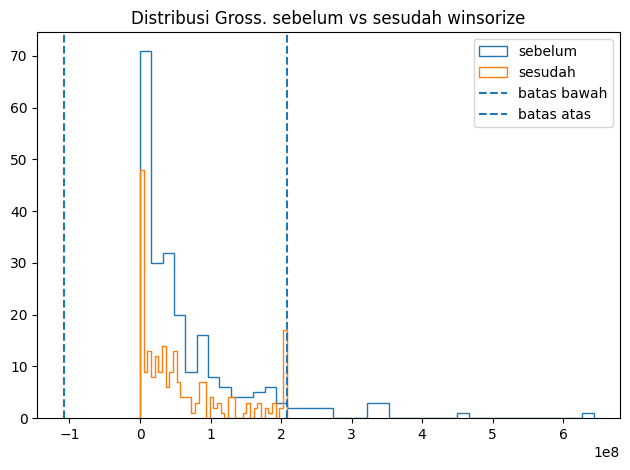

/tmp/ipython-input-1619240810.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_before_outlier[c].dropna(), df[c].dropna()], labels=["sebelum","sesudah"], showfliers=True)


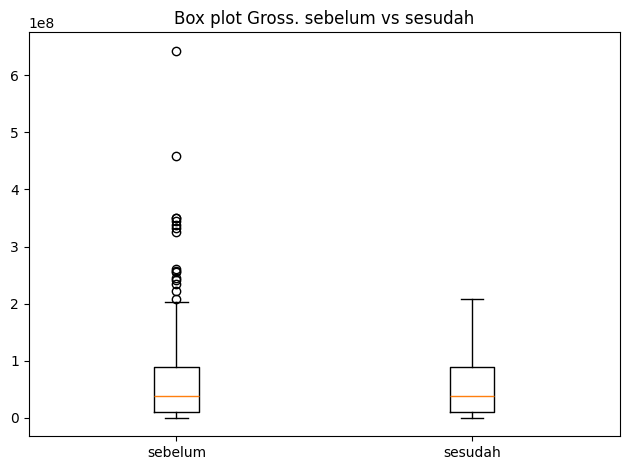

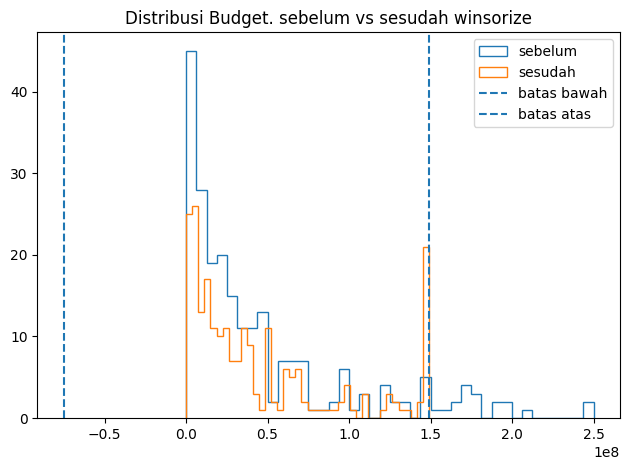

/tmp/ipython-input-1619240810.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_before_outlier[c].dropna(), df[c].dropna()], labels=["sebelum","sesudah"], showfliers=True)


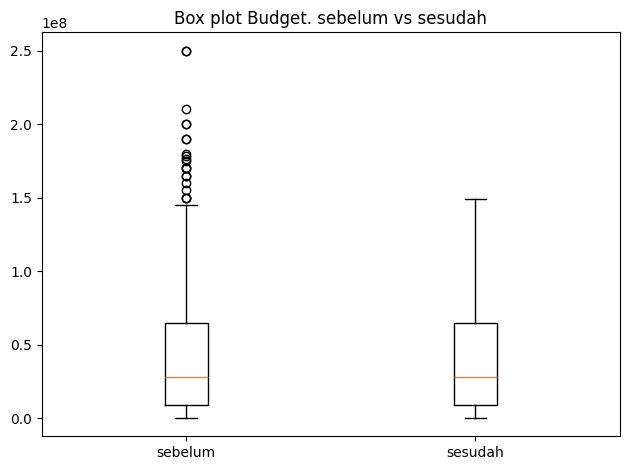

Preview setelah outlier:


,Movie,Year,Gross,Budget,ROI
0,13 Sins,2014.0,9130.0,4000000.0,0.002282
1,22 Jump Street,2014.0,192000000.0,50000000.0,3.840000
2,3 Days to Kill,2014.0,30700000.0,28000000.0,1.096429
3,300: Rise of an Empire,2014.0,106000000.0,110000000.0,0.963636
4,A Haunted House 2,2014.0,17300000.0,3500000.0,4.942857
5,A Long Way Off,2014.0,29000.0,500000.0,0.058000
6,A Million Ways to Die in the West,2014.0,42600000.0,40000000.0,1.065000
7,A Most Violent Year,2014.0,5750000.0,20000000.0,0.287500
8,A Walk Among the Tombstones,2014.0,26000000.0,28000000.0,0.928571
9,About Last Night,2014.0,48600000.0,12500000.0,3.888000


In [6]:
# Step 5. Outlier, winsorize Gross dan Budget

# Simpan salinan sebelum koreksi untuk perbandingan
df_before_outlier = df.copy()

# Kolom target dan parameter
FIX_OUTLIER_COLS = ["Gross","Budget"]
WINSOR_K = 1.5
BINS_HIST = 40

# Fungsi IQR dan batas
def iqr_stats(s, k=1.5):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return q1, q3, iqr, q1 - k*iqr, q3 + k*iqr

# Winsorize setiap kolom target
fix_cols = [c for c in FIX_OUTLIER_COLS if c in df.columns]
recap, bounds = [], []

for c in fix_cols:
    q1, q3, iqr, low, high = iqr_stats(df[c], k=WINSOR_K)
    bounds.append({"column": c, "Q1": q1, "Q3": q3, "IQR": iqr, "lower": low, "upper": high})

    before = pd.to_numeric(df[c], errors="coerce")
    df[c] = before.clip(lower=low, upper=high)
    recap.append({
        "column": c,
        "low_capped": int((before < low).sum()),
        "high_capped": int((before > high).sum())
    })

print("Ringkasan winsorizing:")
display(pd.DataFrame(recap).set_index("column"))
print("Batas IQR:")
display(pd.DataFrame(bounds).set_index("column").round(3))

# Hitung ulang ROI agar konsisten
if {"Gross","Budget"}.issubset(df.columns):
    df["ROI"] = np.where(df["Budget"] > 0, df["Gross"] / df["Budget"], np.nan)

# Visual
for c in fix_cols:
    q1, q3, iqr, low, high = iqr_stats(df_before_outlier[c], k=WINSOR_K)

    plt.figure()
    plt.hist(df_before_outlier[c].dropna(), bins=BINS_HIST, histtype="step", label="sebelum")
    plt.hist(df[c].dropna(),             bins=BINS_HIST, histtype="step", label="sesudah")
    plt.axvline(low,  linestyle="--", label="batas bawah")
    plt.axvline(high, linestyle="--", label="batas atas")
    plt.title(f"Distribusi {c}. sebelum vs sesudah winsorize")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"figs/hist_{c}_before_after.png", dpi=150)
    plt.show()

    plt.figure()
    plt.boxplot([df_before_outlier[c].dropna(), df[c].dropna()], labels=["sebelum","sesudah"], showfliers=True)
    plt.title(f"Box plot {c}. sebelum vs sesudah")
    plt.tight_layout()
    plt.savefig(f"figs/box_{c}_before_after.png", dpi=150)
    plt.show()

# Preview ringkas setelah outlier
print("Preview setelah outlier:")
cols_show = [c for c in ["Movie","Year","Gross","Budget","ROI"] if c in df.columns]
if cols_show:
  display(df[cols_show].head(10))

# Step 6. Cek Redundansi Atribut
Tujuan: Menilai apakah ada atribut yang sangat berkorelasi sehingga berpotensi redundant.

Metode yang digunakan: Matriks korelasi untuk Views, Likes, Dislikes, Comments, Aggregate Followers.

In [7]:
# Step 6. Cek redundansi
social_cols = [c for c in ["Views","Likes","Dislikes","Comments","Aggregate Followers"] if c in df.columns]
if len(social_cols) >= 2:
    corr = df[social_cols].corr(method="pearson").abs()
    print("Korelasi antar metrik sosial:")
    display(corr)

    pairs = []
    for i, a in enumerate(social_cols):
        for b in social_cols[i+1:]:
            pairs.append((a, b, corr.loc[a, b]))
    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)
    print("Pasangan korelasi:")
    for a, b, v in pairs[:20]:
        print(f"{a} vs {b}: {v:.3f}")
else:
    print("Metrik sosial tidak lengkap. Lewati cek redundansi.")

Korelasi antar metrik sosial:


,Views,Likes,Dislikes,Comments,Aggregate Followers
Views,1.000000,0.676876,0.775796,0.710125,0.159283
Likes,0.676876,1.000000,0.470099,0.917421,0.087796
Dislikes,0.775796,0.470099,1.000000,0.579456,0.061559
Comments,0.710125,0.917421,0.579456,1.000000,0.042352
Aggregate Followers,0.159283,0.087796,0.061559,0.042352,1.000000


Pasangan korelasi:
Likes vs Comments: 0.917
Views vs Dislikes: 0.776
Views vs Comments: 0.710
Views vs Likes: 0.677
Dislikes vs Comments: 0.579
Likes vs Dislikes: 0.470
Views vs Aggregate Followers: 0.159
Likes vs Aggregate Followers: 0.088
Dislikes vs Aggregate Followers: 0.062
Comments vs Aggregate Followers: 0.042


# Step 7. Keputusan Kolom Sentiment
Tujuan: Menentukan apakah kolom Sentiment dipertahankan.

Alasan: Sentiment pada dataset ini banyak yang bernilai 0.

Kriteria hapus: Proporsi 0 ≥ 0.90 atau varians sangat rendah, dan korelasi absolut dengan Gross serta ROI < 0.05.



In [8]:
# Step 7. Keputusan kolom Sentiment
import numpy as np
import pandas as pd

if "Sentiment" in df.columns:
    s = pd.to_numeric(df["Sentiment"], errors="coerce")
    zero_ratio = (s == 0).mean() if len(s) else np.nan
    nunique = s.nunique(dropna=True)
    var = float(s.var()) if s.notna().any() else np.nan

    corr_gross = df["Gross"].corr(s) if {"Gross"}.issubset(df.columns) else np.nan
    corr_roi   = df["ROI"].corr(s)   if {"ROI"}.issubset(df.columns)   else np.nan

    print("Sentiment check")
    print(f"- proporsi 0: {zero_ratio:.3f}")
    print(f"- unique values: {nunique}")
    print(f"- variance: {var:.3f}" if not np.isnan(var) else "- variance: NaN")
    print(f"- corr(Sentiment, Gross): {corr_gross:.3f}" if not np.isnan(corr_gross) else "- corr dengan Gross: NaN")
    print(f"- corr(Sentiment, ROI)  : {corr_roi:.3f}"   if not np.isnan(corr_roi)   else "- corr dengan ROI  : NaN")

    VERY_MANY_ZEROS = zero_ratio >= 0.90
    VERY_LOW_VAR    = (not np.isnan(var)) and var < 1e-6
    WEAK_CORR       = (np.isnan(corr_gross) or abs(corr_gross) < 0.05) and (np.isnan(corr_roi) or abs(corr_roi) < 0.05)

    DROP_SENTIMENT = (VERY_MANY_ZEROS or VERY_LOW_VAR) and WEAK_CORR

    if DROP_SENTIMENT:
        df.drop(columns=["Sentiment"], inplace=True)
        print("Keputusan. Sentiment DIHAPUS karena hampir semua 0 atau varians sangat rendah dan korelasi lemah.")
    else:
        print("Keputusan. Sentiment DIPERTAHANKAN karena masih ada variasi atau korelasi yang berguna.")
else:
    print("Kolom Sentiment tidak ada. Lewati.")


Sentiment check
- proporsi 0: 0.465
- unique values: 25
- variance: 33.166
- corr(Sentiment, Gross): 0.036
- corr(Sentiment, ROI)  : 0.017
Keputusan. Sentiment DIPERTAHANKAN karena masih ada variasi atau korelasi yang berguna.


# Step 8. Keputusan PCA
Tujuan: Memutuskan apakah PCA dibutuhkan untuk reduksi dimensi.

Kriteria sederhana: Jika korelasi maksimum antar metrik sosial sangat tinggi, PCA dipertimbangkan. Jika tidak, PCA tidak perlu.

In [9]:
# Step 8. Keputusan PCA
NEED_PCA = False
if len(social_cols) >= 2:
    max_corr = df[social_cols].corr().abs().where(~np.eye(len(social_cols), dtype=bool)).max().max()
    print(f"Maks korelasi absolut antar metrik sosial: {max_corr:.3f}")
    NEED_PCA = bool(max_corr >= 0.92)
else:
    print("Cek PCA dilewati. Metrik sosial tidak lengkap.")

print("Keputusan PCA:", "Perlu" if NEED_PCA else "Tidak perlu")

Maks korelasi absolut antar metrik sosial: 0.917
Keputusan PCA: Tidak perlu


# Step 9. Dataset Final
Tujuan: Menyimpan hasil preprocessing untuk analisis dan visual.

Saved csm_final_minimal.csv. Shape: (230, 16)


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers,ROI,EngagementRate
0,13 Sins,2014.0,6.3,8.0,9130.0,4000000.0,45.0,1.0,0.0,3280543.0,4632.0,425.0,636.0,1120000.0,0.002282,0.001606
1,22 Jump Street,2014.0,7.1,1.0,192000000.0,50000000.0,3306.0,2.0,2.0,583289.0,3465.0,61.0,186.0,12350000.0,3.840000,0.006259
2,3 Days to Kill,2014.0,6.2,1.0,30700000.0,28000000.0,2872.0,1.0,0.0,304861.0,328.0,34.0,47.0,483000.0,1.096429,0.001230
3,300: Rise of an Empire,2014.0,6.3,1.0,106000000.0,110000000.0,3470.0,2.0,0.0,452917.0,2429.0,132.0,590.0,568000.0,0.963636,0.006666
4,A Haunted House 2,2014.0,4.7,8.0,17300000.0,3500000.0,2310.0,2.0,0.0,3145573.0,12163.0,610.0,1082.0,1923800.0,4.942857,0.004211
5,A Long Way Off,2014.0,4.6,3.0,29000.0,500000.0,2486.0,1.0,0.0,91137.0,112.0,7.0,1.0,310000.0,0.058000,0.001240
6,A Million Ways to Die in the West,2014.0,6.1,8.0,42600000.0,40000000.0,3158.0,1.0,0.0,3013011.0,9595.0,419.0,1020.0,8153000.0,1.065000,0.003523
7,A Most Violent Year,2014.0,7.1,1.0,5750000.0,20000000.0,818.0,1.0,2.0,1854103.0,2207.0,197.0,593.0,130655.0,0.287500,0.001510
8,A Walk Among the Tombstones,2014.0,6.5,10.0,26000000.0,28000000.0,2714.0,1.0,3.0,2213659.0,2210.0,419.0,382.0,125646.0,0.928571,0.001171
9,About Last Night,2014.0,6.1,8.0,48600000.0,12500000.0,2253.0,1.0,0.0,5218079.0,11709.0,532.0,770.0,21697300.0,3.888000,0.002391


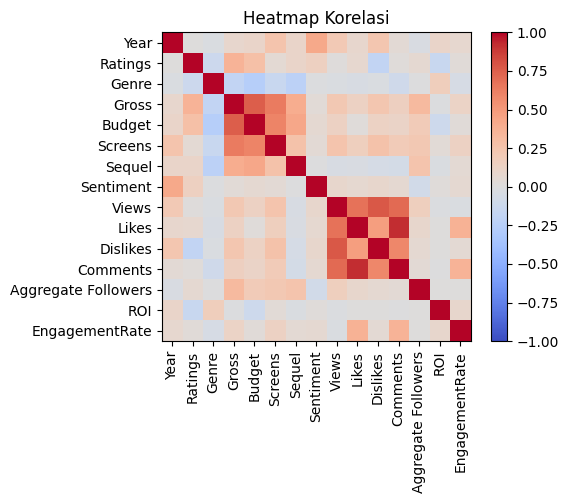

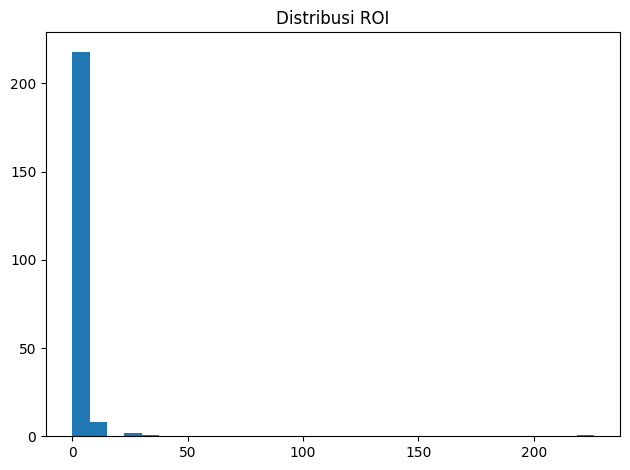

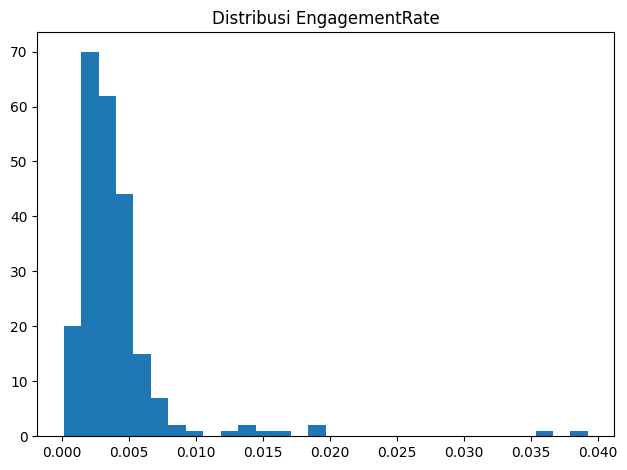

In [10]:
# Step 9. Dataset final
cols_keep = [c for c in [
    "Movie","Year","Ratings","Genre","Gross","Budget","Screens","Sequel",
    "Sentiment","Views","Likes","Dislikes","Comments","Aggregate Followers",
    "ROI","EngagementRate","PC1","PC2","PC3"
] if c in df.columns]

df_final = df[cols_keep].copy()
df_final.to_csv("csm_final_minimal.csv", index=False)
print("Saved csm_final_minimal.csv. Shape:", df_final.shape)
preview(df_final, 10)

# Heatmap korelasi akhir
num_cols_final = df_final.select_dtypes(include=[np.number]).columns
if len(num_cols_final) >= 2:
    corr = df_final[num_cols_final].corr()
    plt.figure(figsize=(6, 5))
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(num_cols_final)), num_cols_final, rotation=90)
    plt.yticks(range(len(num_cols_final)), num_cols_final)
    plt.title("Heatmap Korelasi")
    plt.tight_layout()
    plt.savefig("figs/corr_final.png", dpi=150)
    plt.show()

# Histogram ROI dan EngagementRate
for col in ["ROI", "EngagementRate"]:
    if col in df_final.columns:
        plt.figure()
        plt.hist(df_final[col].dropna(), bins=30)
        plt.title(f"Distribusi {col}")
        plt.tight_layout()
        plt.savefig(f"figs/hist_{col}.png", dpi=150)
        plt.show()

# Step 10. Ringkasan dan Insight
Tujuan: Memberi angka ringkas dan hubungan sederhana setelah preprocessing.

Ringkasan per tahun. median, mean, std:


Gross                                  Budget                                ROI                EngagementRate              
            median          mean           std      median          mean           std median   mean     std         median   mean    std
Year                                                                                                                                     
2014.0  38200000.0  5.733366e+07  6.310884e+07  24000000.0  4.180989e+07  4.501830e+07  1.162  2.091   3.661          0.003  0.004  0.005
2015.0  36750000.0  6.900265e+07  6.681617e+07  35000000.0  5.255581e+07  4.989022e+07  1.374  5.463  27.338          0.004  0.005  0.003

Top 10 ROI per tahun:


,Year,Movie,ROI,Gross,Budget
0,2014.0,God's Not Dead,30.400000,60800000.0,2000000.0
1,2014.0,The Woman in Black 2: Angel of Death,26.500000,26500000.0,1000000.0
2,2014.0,Annabelle,12.969231,84300000.0,6500000.0
3,2014.0,The Fault in Our Stars,10.416667,125000000.0,12000000.0
4,2014.0,Ouija,10.160000,50800000.0,5000000.0
5,2014.0,Neighbors,8.333333,150000000.0,18000000.0
6,2014.0,The Purge: Anarchy,7.944444,71500000.0,9000000.0
7,2014.0,Heaven Is for Real,7.616667,91400000.0,12000000.0
8,2014.0,It Follows,7.350000,14700000.0,2000000.0
9,2014.0,The Imitation Game,6.507143,91100000.0,14000000.0


Korelasi kolom sosial terhadap target:


,feature,target,pearson_r
6,Aggregate Followers,Gross,0.319
0,Views,Gross,0.212
4,Comments,Gross,0.153
2,Likes,Gross,0.133
3,Likes,ROI,0.007
7,Aggregate Followers,ROI,0.001
5,Comments,ROI,-0.004
1,Views,ROI,-0.021


Scatter Gross vs Budget:


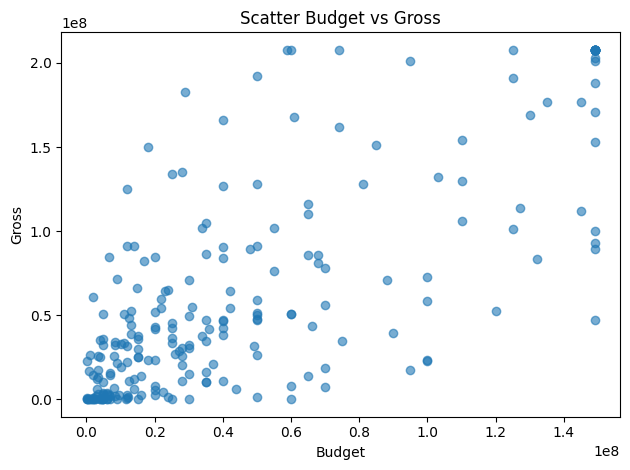

ROI vs Ratings:


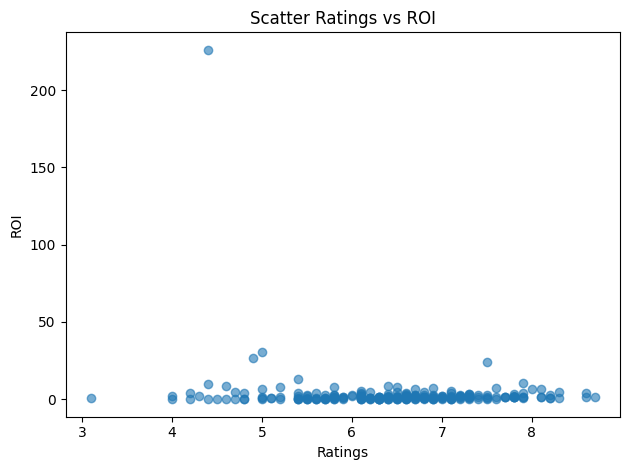

In [11]:
# Step 10. Ringkasan dan insight singkat

# Ringkasan per tahun
cols_summary = [c for c in ["Gross","Budget","ROI","EngagementRate"] if c in df.columns]
if "Year" in df.columns and cols_summary:
    agg = df.groupby("Year")[cols_summary].agg(["median","mean","std"])
    print("Ringkasan per tahun. median, mean, std:")
    display(agg.round(3))

# Top 10 ROI per tahun
if {"Movie","Year","ROI"}.issubset(df.columns):
    top_roi = (
        df.dropna(subset=["ROI"])
          .sort_values(["Year","ROI"], ascending=[True, False])
          .groupby("Year")
          .head(10)[["Year","Movie","ROI","Gross","Budget"]]
    )
    print("Top 10 ROI per tahun:")
    display(top_roi.reset_index(drop=True))

# Korelasi sederhana untuk hubungan sosial vs performa
pairs = []
targets_left  = [c for c in ["Views","Likes","Comments","Aggregate Followers"] if c in df.columns]
targets_right = [c for c in ["Gross","ROI"] if c in df.columns]
for a in targets_left:
    for b in targets_right:
        r = df[a].corr(df[b])
        pairs.append((a, b, r))
if pairs:
    corr_tbl = pd.DataFrame(pairs, columns=["feature","target","pearson_r"]).sort_values("pearson_r", ascending=False)
    print("Korelasi kolom sosial terhadap target:")
    display(corr_tbl.round(3))

# Scatter Gross vs Budget dan ROI vs Ratings
print("Scatter Gross vs Budget:")
if {"Gross","Budget"}.issubset(df.columns):
    plt.figure()
    plt.scatter(df["Budget"], df["Gross"], alpha=0.6)
    plt.xlabel("Budget"); plt.ylabel("Gross"); plt.title("Scatter Budget vs Gross")
    plt.tight_layout(); plt.savefig("figs/scatter_budget_gross.png", dpi=150); plt.show()

print("ROI vs Ratings:")
if {"Ratings","ROI"}.issubset(df.columns):
    plt.figure()
    plt.scatter(df["Ratings"], df["ROI"], alpha=0.6)
    plt.xlabel("Ratings"); plt.ylabel("ROI"); plt.title("Scatter Ratings vs ROI")
    plt.tight_layout(); plt.savefig("figs/scatter_ratings_roi.png", dpi=150); plt.show()
